In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
import statistics
from scipy.io import loadmat
import scipy.stats
from astropy.stats import bayesian_blocks
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle
import matplotlib.text as mtext
import seaborn as sns

# slightly nicer figures
sns.set_theme(style='white')
sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'w'})



class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title

In [2]:
"""LOAD IN SYNTHETIC DATA"""

#load synthetic storm properties - all storms
storms = pd.read_csv("syn_props_necp_full.csv")

#load files given by Amir for properties of synthetic storms that breach threshold
dis = loadmat('k.mat')['k'][0]
rm = loadmat('r.mat')['r'][0]
theta = loadmat('t.mat')['t'][0]
vm = loadmat('v.mat')['v'][0]

surge = loadmat('Max_Surge_LIBH.mat')['Max_surge_LIBH'][0]

#put thresholf breaching synthetic storms into one datafram
s_thresh = pd.DataFrame({"Closest Passage (km)": dis, "Rm_rmin": rm, "Vm_rmin": vm, "Theta_uh": theta, "pass_libh":dis, "max_surge": surge})

#add component parts of path trajectory
s_thresh["V"] = np.sin(np.deg2rad(s_thresh.Theta_uh+120.9228)) #120.9228˚ = reference degree of Long Island wrt east
s_thresh["U"] = np.cos(np.deg2rad(s_thresh.Theta_uh+120.9228))

s_thresh.head()

,Closest Passage (km),Rm_rmin,Vm_rmin,Theta_uh,pass_libh,max_surge,V,U
0,30.164939,59.26400,22.774259,-12.617174,30.164939,0.678938,0.949395,-0.314086
1,38.557699,64.57924,28.510265,6.211145,38.557699,0.767476,0.797226,-0.603680
2,15.255632,38.31788,48.563136,28.113456,15.255632,0.760906,0.514496,-0.857493
3,12.648562,41.52184,44.761424,-63.118521,12.648562,0.956284,0.846233,0.532813
4,101.300000,72.28000,38.580000,-18.640460,101.300000,0.751186,0.977111,-0.212729


In [3]:
# #check how magnitude of surge changes with storm intensity
# fig, ax = plt.subplots(figsize = (8,3))
# ax.plot(s_thresh["Vm_rmin"], s_thresh.max_surge, 'o')
# ax.set_xlabel("Intensity (m/s)"); ax.set_ylabel("Surge (m)"); ax.set_title("Surge vs Intensity")
# plt.show()


In [4]:
"""LOAD IN HISTORIC STORMS"""

#historic properties from IBTRACS
storms_hist = pd.read_csv("../libh_hist_storms.csv")
storms_hist = storms_hist[(storms_hist.Year >=1988) & (storms_hist.Year <=2015)] #isolate modern storms

storms_hist["Max Surge (m)"] = storms_hist["Maximum surge (m)"] #new column with easier name
storms_hist["pass_libh"] = np.copy(storms_hist["Closest Passage (km)"]) #I was copying and adjusting this column but rn it's just a copy
# storms_hist["pass_libh"][(storms_hist["Angle of Passage"] > 125)  & (storms_hist["Angle of Passage"] < 310)] = -1*storms_hist["pass_libh"][(storms_hist["Angle of Passage"] > 125)&(storms_hist["Angle of Passage"] < 310)]
storms_hist.Rm_rmin = storms_hist.Rm_rmin*1.852

#PRE 1950 STORMS
storms_p_1950 = pd.read_csv('../pre_1950_hist.csv')
storms_p_1950['pass_libh'] = storms_p_1950.r_min
# storms_p_1950['pass_libh'][storms_p_1950.u > 0] = -storms_p_1950.r_min
storms_p_1950= storms_p_1950.rename(columns={"u": "U", "v": "V"})
# storms_p_1950.Rm_rmin = storms_p_1950.Rm_rmin*1.852


In [5]:
def quiver(ax, df, ind):
    U = df.U; V = df.V
    U_norm = U / np.sqrt(U**2 + V**2); V_norm = V / np.sqrt(U**2 + V**2)

    ax.quiver(df.pass_libh[ind], df.Vm_rmin[ind], 
              U_norm[ind]/100, V_norm[ind]/100,  alpha = .5, scale = .65)


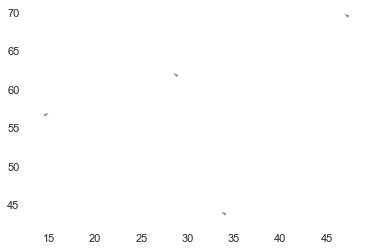

In [6]:
U = storms_p_1950.U; V = storms_p_1950.V
U_norm = U / np.sqrt(U**2 + V**2); V_norm = V / np.sqrt(U**2 + V**2)

plt.quiver(storms_p_1950.pass_libh, storms_p_1950.Vm_rmin, 
              U_norm/100, V_norm/100,  alpha = .5, scale = .65)

<ipython-input-7-501a6ce6755e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storms_hist.Rm_rmin[storms_hist.Rm_rmin<0] = 5  #set a very small Rm value for storms missing it so they will show up on figure


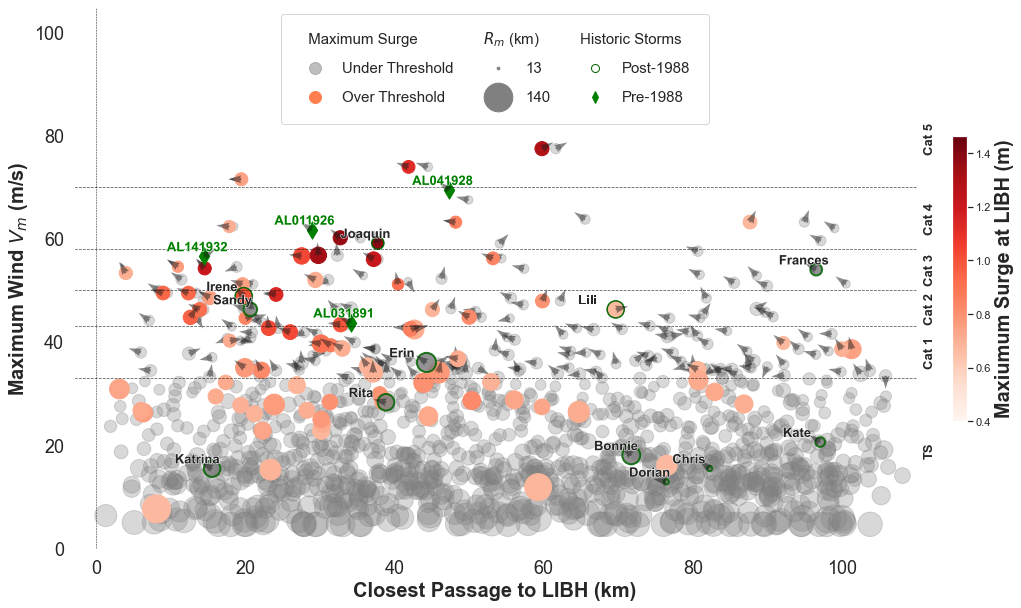

In [7]:
#BUBBLE PLOT INSPIRED BY LIN 2014
thresh=.67
min_ = .4#min(node_surge[node_surge>thresh])
max_ = max(s_thresh.max_surge)+.1
fig, ax = plt.subplots(figsize = (16,10))
ax.set_facecolor("white")

scat = ax.scatter(storms["pass_libh"], storms["Vm_rmin"], s = storms["Rm_rmin"]*5, #multiply by 5 so that size fits figure better
                    alpha = .3, c= "grey",
                    vmin=min_, vmax=max_, label = "Under Threshold")



quiver(ax, storms, storms["Vm_rmin"]>=33.)


#SYNTHETIC > THRESHOLD
scatter2 = ax.scatter(s_thresh.pass_libh, s_thresh.Vm_rmin, s = s_thresh.Rm_rmin*5, c = s_thresh.max_surge,
           cmap = "Reds", vmin=min_, vmax=max_, label = "Over Threshold")

cb = plt.colorbar(scatter2, fraction=0.016, pad=0.04)
cb.set_label(label = "Maxiumum Surge at LIBH (m)", weight='bold', fontsize = 20)

quiver(ax, s_thresh, s_thresh.Vm_rmin>=33.)

#HISTORIC STORMS
storms_hist.Rm_rmin[storms_hist.Rm_rmin<0] = 5  #set a very small Rm value for storms missing it so they will show up on figure
scatter1 = ax.scatter(storms_hist.pass_libh, storms_hist.Vm_rmin, s = storms_hist.Rm_rmin*5, 
                     c= "grey",alpha = .85, edgecolor = 'darkgreen', linewidth = 2.,
                    ) #vmin=min_, vmax=max_

ind = storms_hist["Max Surge (m)"]>=thresh
scatter1 = ax.scatter(storms_hist.pass_libh[ind], storms_hist.Vm_rmin[ind], s = storms_hist.Rm_rmin[ind]*5, 
                     c = storms_hist["Max Surge (m)"][ind], cmap = "Reds",
                    vmin=min_, vmax=max_, edgecolor = 'darkgreen', )


quiver(ax, storms_hist, s_thresh.Vm_rmin>=0.)


#PRE 1988
scatter3 = ax.scatter(storms_p_1950.pass_libh, storms_p_1950.Vm_rmin, marker = 'd',
                     s = 150, c = "green", edgecolor = 'green')

quiver(ax, storms_p_1950, storms_p_1950.Vm_rmin>=0.)


#LABEL HISTORIC STORMS
for i, name in enumerate(storms_hist.Name):
    ax.text(storms_hist.pass_libh.values[i]-5, storms_hist.Vm_rmin.values[i]+1, name, weight='bold', size = 13,
             path_effects=[pe.withStroke(linewidth=1, foreground="w")])


for i, name in enumerate(storms_p_1950.ID):
    ax.text(storms_p_1950.pass_libh.values[i]-5, storms_p_1950.Vm_rmin.values[i]+1, name, weight='bold',
            color = "green", size = 13, path_effects=[pe.withStroke(linewidth=1, foreground="w")])


    #LINES TO MAKE PLOT EASIER TO READ
ax.plot([0,0],[0,200], 'k--', linewidth = .5)

#plot limits for TC classification
min_r_lim = -150; max_r_lim = 150
cat_list = (33, 43, 50, 58, 70)
for c in cat_list:
    ax.plot([min_r_lim,max_r_lim], [c,c], 'k--', alpha = .75, linewidth = .75)  #CAT Lines

ax.text(111,18, "TS", fontsize = 13, rotation = 90, weight='bold')
ax.text(111, 35.5, "Cat 1", fontsize = 13, rotation = 90, weight='bold')
ax.text(111, 44, "Cat 2", fontsize = 13, rotation = 90, weight='bold')
ax.text(111, 51.5, "Cat 3", fontsize = 13, rotation = 90, weight='bold')
ax.text(111, 61.5, "Cat 4", fontsize = 13, rotation = 90, weight='bold')
ax.text(111, 77, "Cat 5", fontsize = 13, rotation = 90, weight='bold')





#LEGEND NONESENSE
#threshold
p1, = plt.plot([],[], 'o', alpha = .5, color = "grey", markersize=12); 
p2, = plt.plot([],[], 'o', color = "coral", markersize=12)

#rmax
msizes = [min(storms.Rm_rmin), max(storms.Rm_rmin)]
l1, = plt.plot([],[], 'o', color = "grey", markersize=msizes[0]/5); 
l2, = plt.plot([],[], 'o', color = "grey", markersize=msizes[1]/5)

#historical storms
h1, = plt.plot([],[], 'o', color = "darkgreen", markerfacecolor = "white", markersize=8)
h2, = plt.plot([],[], "d", color = "green", markersize=8)

labels = ["", "Under Threshold", "Over Threshold", "",
          13, 140,
         '', 'Post-1988', 'Pre-1988']
legend = ax.legend(["  Maximum Surge", p1, p2, r'$R_m$ (km)', l1, l2, 'Historic Storms', h1, h2], labels, 
                    ncol=3, frameon=True, fontsize=15, borderpad = 1.25,
                  labelspacing=1,  loc = "upper center", handler_map={str: LegendTitle({'fontsize': 15})})


#AXES AND PLOT LABELS
ax.set_ylim([np.min(storms["Vm_rmin"])-5, 70+35]); ax.set_xlim([-3, 110])

ax.set_ylabel(r"Maximum Wind $V_m$ (m/s)", fontsize = 20, fontweight="bold")
ax.set_xlabel(r"Closest Passage to LIBH (km)", fontsize = 20,  fontweight="bold")
# ax.get_xaxis().set_visible(False)
ax.grid(False)

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)


plt.savefig('bubble_wsurge_dir.png') #, transparent=True
plt.show()



In [8]:
ind = storms_hist["Max Surge (m)"] >= .67
data = pd.DataFrame({"pass_libh": (s_thresh["pass_libh"].append(storms_hist[ind]['pass_libh'])).append(storms_p_1950.pass_libh),
                     "Vm_rmin": (s_thresh["Vm_rmin"].append(storms_hist[ind]['Vm_rmin'])).append(storms_p_1950.Vm_rmin),
                     "Rm_rmin": list(s_thresh["Rm_rmin"].append(storms_hist[ind]['Rm_rmin'])) + (list(np.zeros(4))),
                     "U": (s_thresh["U"].append(storms_hist[ind]['U'])).append(storms_p_1950.U),
                    "V": (s_thresh["V"].append(storms_hist[ind]['V'])).append(storms_p_1950.V),
                     "classif": np.array(list(np.ones(80))+list(np.zeros(4)))
                    }) #                     


data["Theta"] = np.degrees(np.arctan2(data.V,data.U))% 360.0
data

,pass_libh,Vm_rmin,Rm_rmin,U,V,classif,Theta
0,30.164939,22.774259,59.26400,-0.314086,0.949395,1.0,108.305626
1,38.557699,28.510265,64.57924,-0.603680,0.797226,1.0,127.133945
2,15.255632,48.563136,38.31788,-0.857493,0.514496,1.0,149.036256
3,12.648562,44.761424,41.52184,0.532813,0.846233,1.0,57.804279
4,101.300000,38.580000,72.28000,-0.212729,0.977111,1.0,102.282340
...,...,...,...,...,...,...,...
9,69.665567,46.299960,55.56000,2.000000,0.500000,1.0,14.036243
0,14.490000,56.588840,0.00000,1.290000,0.800000,0.0,31.805329
1,47.380000,69.449940,0.00000,-1.200000,0.900000,0.0,143.130102
2,28.911000,61.733280,0.00000,-0.899000,0.600000,0.0,146.280527


In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def clustering(clusters, data):
    # clusters = 11

    kmeans = KMeans(n_clusters = clusters)

    data_ = data[["pass_libh", "Vm_rmin", "Theta"]]
    kmeans.fit_predict(data_)

#     print(kmeans.labels_)
    data_clus = pd.DataFrame.copy(data)
    
    data_clus["Label"] = kmeans.labels_
#     print(data_clus.head())
    return data_clus

In [10]:
#normalize data due to different units and magnitudes
def scale_and_cluster(data, cluster_n):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data)

    df = pd.DataFrame(scaled_features, columns = ["pass_libh", "Vm_rmin", "Rm_rmin", "U", "V", 'classif', "Theta"])



    clusters = cluster_n
    data_clus_scale = clustering(clusters, df)

    #inverse scale
    data_clus_inv = scaler.inverse_transform(data_clus_scale.iloc[:,:-1])
    data_clus = pd.DataFrame(data_clus_inv, columns = ["pass_libh", "Vm_rmin", "Rm_rmin", "U", "V", 'classif', "Theta"])
    data_clus["Label"] = data_clus_scale.Label
    data_clus
    
    return data_clus

In [11]:

def plot_clusters(data_clus, storms_hist, storms_p_1950, clusters):
    fig, ax = plt.subplots(figsize = (16,10))
    ax.set_facecolor("white")

    ax2 = ax.twiny()


    thresh = 0.67


    #NEW RUNS!!!!!!!
    ind = data_clus.classif >0 

    scatter2 = ax2.scatter(data_clus['pass_libh'][ind], data_clus.Vm_rmin[ind], s= 5*data_clus.Rm_rmin[ind],
                           c = data_clus.Label[ind],  cmap = "tab20", vmax = clusters, vmin = 0)

    print("Post 1988 Historical: ", list(data_clus[-7:-4].Label))
    
    scatter2_5 = ax2.scatter(data_clus['pass_libh'][-7:-4], data_clus.Vm_rmin[-7:-4], s= 5*data_clus.Rm_rmin[-7:-4],
                           c = data_clus.Label[-7:-4],  cmap = "tab20", 
                             edgecolor = "darkgreen", vmax = clusters, vmin = 0)

    ind = data_clus.classif <1 
    # scatter3 = ax2.scatter(storms_p_1950.pass_libh, storms_p_1950.Vm_rmin, marker = 'd',
    #                      s = 100, c = "green", edgecolor = 'green')

    scatter3 = ax2.scatter(data_clus['pass_libh'][ind], data_clus.Vm_rmin[ind], s= 200,  marker = 'd',
                           c = data_clus.Label[ind],  cmap = "tab20", edgecolor = "darkgreen",
                           vmax = clusters, vmin = 0)

    print("Pre 1988 Historical: ", list(data_clus.Label[-4:]))

    U = data_clus.U; V = data_clus.V
    U_norm = U / np.sqrt(U**2 + V**2); V_norm = V / np.sqrt(U**2 + V**2)

    ax2.quiver(data_clus['pass_libh'], data_clus.Vm_rmin, U_norm/100, V_norm/100,  alpha = .5, scale = .65)

    #LABEL HISTORIC STORMS
    for i, name in enumerate(storms_hist.Name):
        if name in ["Joaquin" , "Lili" , "Irene"]:
            ax2.text(storms_hist.pass_libh.values[i]-5, storms_hist.Vm_rmin.values[i]+1, name, weight='bold', size = 13)


    for i, name in enumerate(storms_p_1950.ID):
        ax2.text(storms_p_1950.pass_libh.values[i]-5, storms_p_1950.Vm_rmin.values[i]+1, name, weight='bold',
                color = "green", size = 13, path_effects=[pe.withStroke(linewidth=1, foreground="w")])


        #LINES TO MAKE PLOT EASIER TO READ
    ax.plot([0,0],[0,200], 'k--', linewidth = .5)

    #plot limits for TC classification
    min_r_lim = -150
    max_r_lim = 150

    ax.plot([min_r_lim,max_r_lim], [33,33], 'k--', alpha = .75, linewidth = .75)  #CAT 1
    ax.plot([min_r_lim,max_r_lim], [43,43], 'k--', alpha = .75, linewidth = .75)  #CAT 2
    ax.plot([min_r_lim,max_r_lim], [50,50], 'k--', alpha = .75, linewidth = .75)  #CAT 3
    ax.plot([min_r_lim,max_r_lim], [58,58], 'k--', alpha = .75, linewidth = .75)  #CAT 4
    ax.plot([min_r_lim,max_r_lim], [70,70], 'k--', alpha = .75, linewidth = .75)  #CAT 5

    ax.text(111,18, "TS", fontsize = 12, rotation = 90, weight='bold')
    ax.text(111, 35.5, "Cat 1", fontsize = 12, rotation = 90, weight='bold')
    ax.text(111, 44, "Cat 2", fontsize = 12, rotation = 90, weight='bold')
    ax.text(111, 51.5, "Cat 3", fontsize = 12, rotation = 90, weight='bold')
    ax.text(111, 61.5, "Cat 4", fontsize = 12, rotation = 90, weight='bold')
    ax.text(111, 77, "Cat 5", fontsize = 12, rotation = 90, weight='bold')





  #LEGEND NONESENSE
    #threshold
    p1, = plt.plot([],[], 'o', alpha = .5, color = "grey", markersize=12); 
    p2, = plt.plot([],[], 'o', color = "coral", markersize=12)

    #rmax
    msizes = [min(storms.Rm_rmin), max(storms.Rm_rmin)]
    l1, = plt.plot([],[], 'o', color = "grey", markersize=msizes[0]/5); 
    l2, = plt.plot([],[], 'o', color = "grey", markersize=msizes[1]/5)

    #historical storms
    h1, = plt.plot([],[], 'o', color = "darkgreen", markerfacecolor = "white", markersize=8)
    h2, = plt.plot([],[], "d", color = "green", markersize=8)

    labels = ["", "Under Threshold", "Over Threshold", "",
              13, 140,
             '', 'Post-1988', 'Pre-1988']
#     legend = ax.legend(["  Maximum Surge", p1, p2, r'$R_m$ (km)', l1, l2, 'Historic Storms', h1, h2], labels, 
#                         ncol=3, frameon=True, fontsize=12, borderpad = 1.25,
#                       labelspacing=1,  loc = "upper center", handler_map={str: LegendTitle({'fontsize': 12})})

    legend1 = ax2.legend(*scatter2.legend_elements(),ncol=3,
                        loc="upper center", title="Cluster", fontsize = 15)
    legend1.set_title('Cluster',prop={'size':15})

    legend2 = ax2.legend([h1,h2], ["Post-1988 storm", 'Pre-1988 storm'], fontsize = 15)
    ax2.add_artist(legend1)

    #AXES AND PLOT LABELS
    ax.set_ylim([0, 80+25])
    ax2.set_ylim([0, 80+25])

    ax.set_xlim([-3, 110]); ax2.set_xlim([-3, 110])

    ax.set_title("Storm Property Clusters of Deposit Leaving Storms", fontsize = 20, fontweight='bold')
    ax.set_ylabel(r"Maximum Wind Speed (m/s)", fontsize = 20, fontweight='bold')
    ax.set_xlabel(r"Closest Passage to LIBH (km)", fontsize = 20, fontweight='bold')
    ax2.get_xaxis().set_visible(False)
    # ax2.legend(loc = "lower right")

    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)


    ax.grid(False); ax2.grid(False)
    plt.savefig('cluster_bubble.png') #, transparent=True

    plt.show()



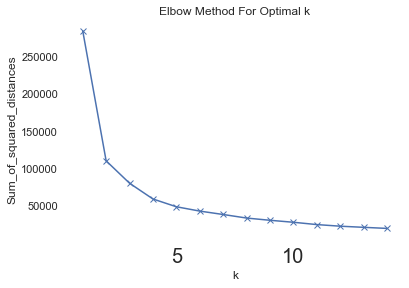

In [27]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

df = pd.DataFrame(scaled_features, columns = ["pass_libh", "Vm_rmin", "Rm_rmin", "U", "V", 'classif', "Theta"])



# data_clus_scale = clustering(clusters, df)


Sum_of_squared_distances = []
K = range(1,15)
for k in K:
#     km = KMeans(n_clusters=k)
    
    km = KMeans(n_clusters = k)

    data_ = data[["pass_libh", "Vm_rmin", "Theta"]]
#     kmeans.fit_predict(data_)
    
    km = km.fit(data_)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Joaquin 8.0 7
Irene 6.0 13
Lili 2.0 4
Post 1988 Historical:  [8, 2, 1]
Pre 1988 Historical:  [1, 8, 8, 0]


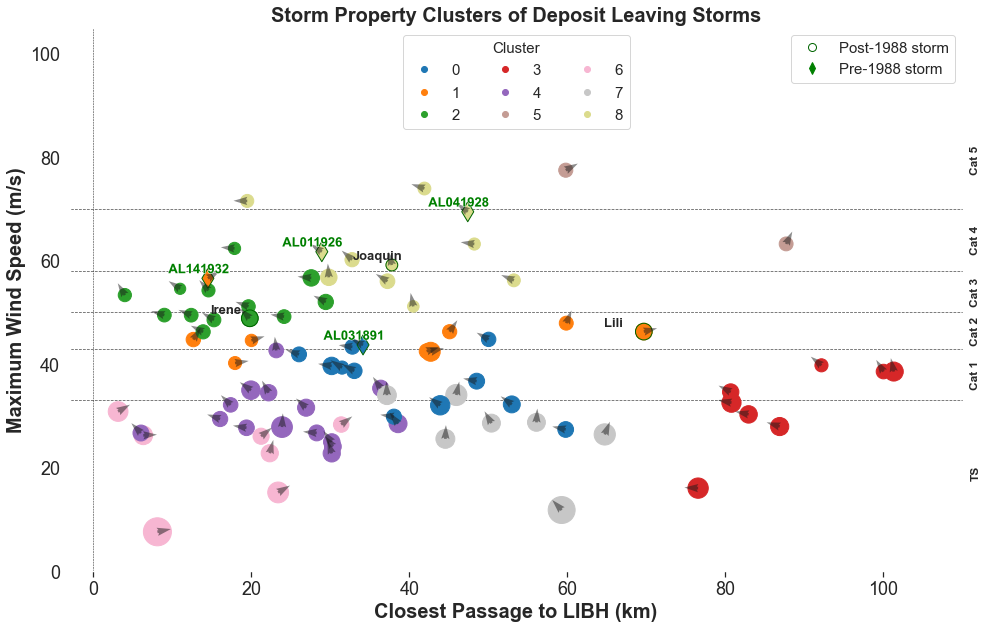

Joaquin 8.0 8
Irene 2.0 12
Lili 1.0 7
Joaquin 6.0 8
Irene 1.0 13
Lili 4.0 3
Joaquin 4.0 7
Irene 0.0 13
Lili 8.0 3
Joaquin 0.0 8
Irene 4.0 13
Lili 7.0 3
Joaquin 0.0 8
Irene 7.0 13
Lili 6.0 3
Joaquin 7.0 5
Irene 8.0 12
Lili 4.0 2
Joaquin 1.0 7
Irene 5.0 11
Lili 4.0 4
Joaquin 1.0 6
Irene 3.0 12
Lili 6.0 2
Joaquin 8.0 10
Irene 1.0 11
Lili 0.0 3


In [30]:





names = ["Joaquin", "Irene", "Lili"]

clus_rm = [[],[],[]]
dis_clus = [[],[],[]]
# all_rm = [[],[],[]]

num_it = 10

for j in range(num_it):
    cluster_n = 9
    data_clus = scale_and_cluster(data, cluster_n)
    if j == 1:
        plot_clusters(data_clus, storms_hist, storms_p_1950, cluster_n)
    data_h = data_clus.iloc[-7:-4] #post 1988 historical storms


    for i in range(0,3):
        storm_unk = data_h.iloc[i]#storms_p_1950[storms_p_1950.ID == "AL141932"]
    #     print(storm_unk)
        clus = storm_unk.Label

        dat = data_clus[:-7] #don't include historical storms -- only using synthetics as proxies

        print(names[i], clus, (len(dat[dat.Label == clus])))



#         fig, ax = plt.subplots(1, 3, figsize = (18,6))
#         fig.suptitle(names[i])
#         ax[0].scatter(dat.pass_libh, dat.Vm_rmin, c='b', s = 5*dat.Rm_rmin, alpha = .5)
#         ax[0].scatter(dat[dat.Label == clus].pass_libh, dat[dat.Label == clus].Vm_rmin, c='g', s=5*dat[dat.Label == clus].Rm_rmin)
#         ax[0].plot(storm_unk.pass_libh, storm_unk.Vm_rmin, 'r*')
#         ax[0].set_title("Cluster Only"); ax[0].set_ylabel("Max Wind (m/s)")

    #     #     print(dat[dat.Label == clus])
    #         print("Actual Rm: ", data_h.Rm_rmin.iloc[i])

    #         print("Cluster Only: \t\t", np.mean(dat.Rm_rmin[dat.Label == clus]),"+-" ,np.std(dat.Rm_rmin[dat.Label == clus]))
        clus_rm[i].extend((dat.Rm_rmin[dat.Label == clus]).values)
#         print(dat.Rm_rmin[dat.Label == clus])
        
        dis = ((dat[dat.Label == clus].Vm_rmin - storm_unk.Vm_rmin)**2 
               + (dat[dat.Label == clus].pass_libh - storm_unk.pass_libh)**2
              + (dat[dat.Label == clus].Theta - storm_unk.Theta)**2)**.5
        dis_clus[i].extend(dis)

        plt.show()

    
# plot_clusters(data_clus, storms_hist, storms_p_1950)    

Post 1988 Historical:  [6, 3, 2]
Pre 1988 Historical:  [7, 6, 6, 3]


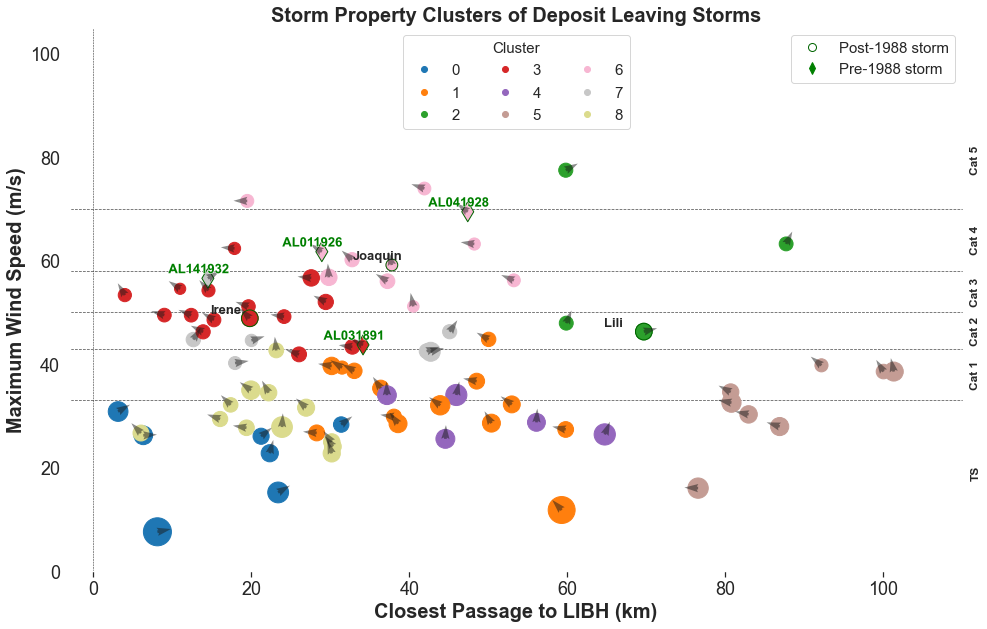

AL141932 7.0 6
AL041928 6.0 8
AL011926 6.0 8
AL031891 3.0 14
Post 1988 Historical:  [1, 6, 2]
Pre 1988 Historical:  [2, 1, 1, 8]


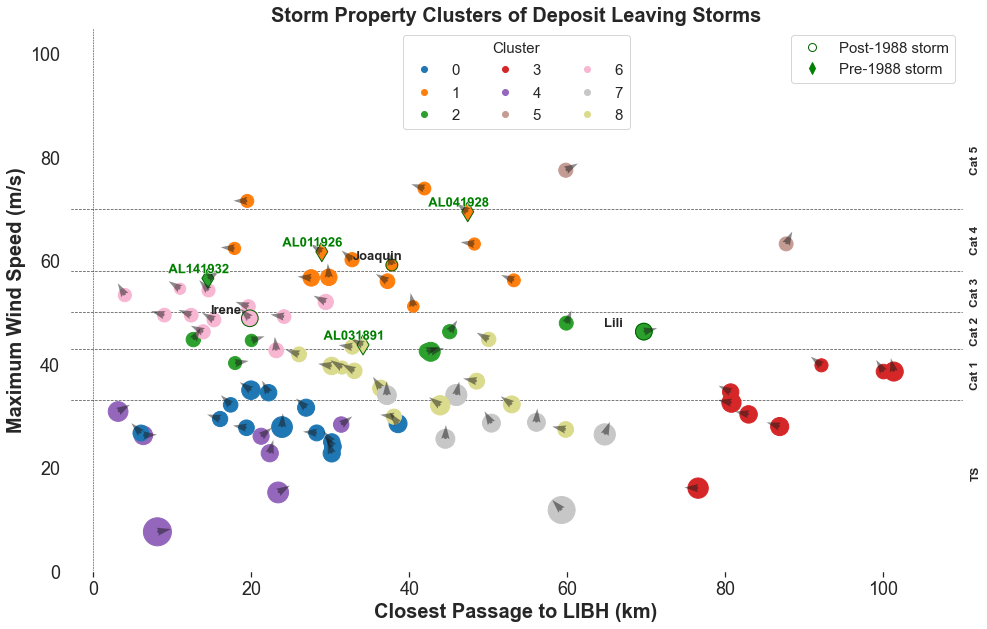

AL141932 2.0 7
AL041928 1.0 10
AL011926 1.0 10
AL031891 8.0 12
Post 1988 Historical:  [3, 7, 0]
Pre 1988 Historical:  [5, 3, 3, 7]


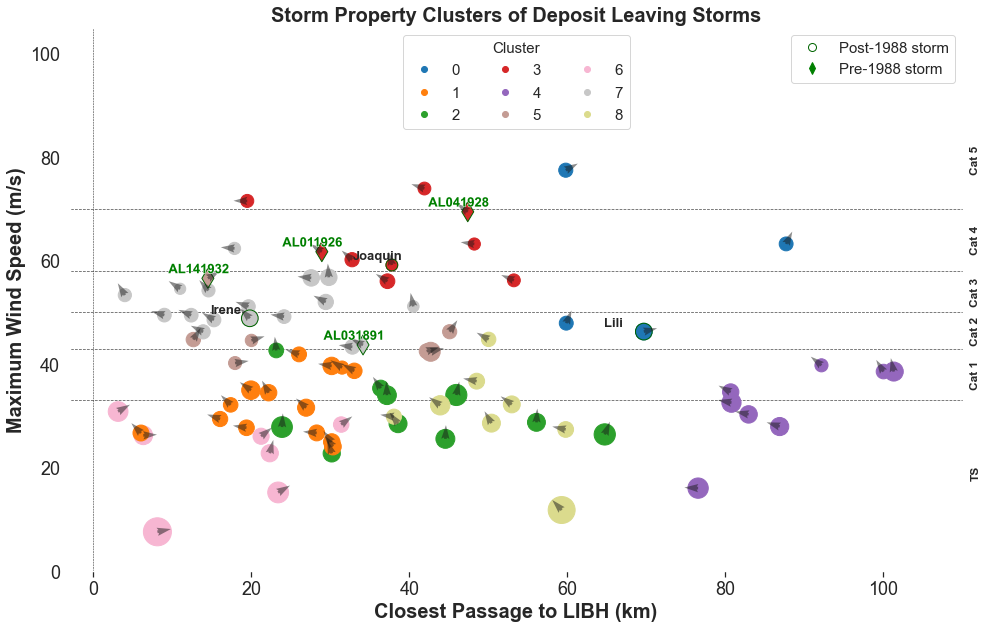

AL141932 5.0 6
AL041928 3.0 6
AL011926 3.0 6
AL031891 7.0 15
Post 1988 Historical:  [0, 7, 3]
Pre 1988 Historical:  [6, 0, 0, 4]


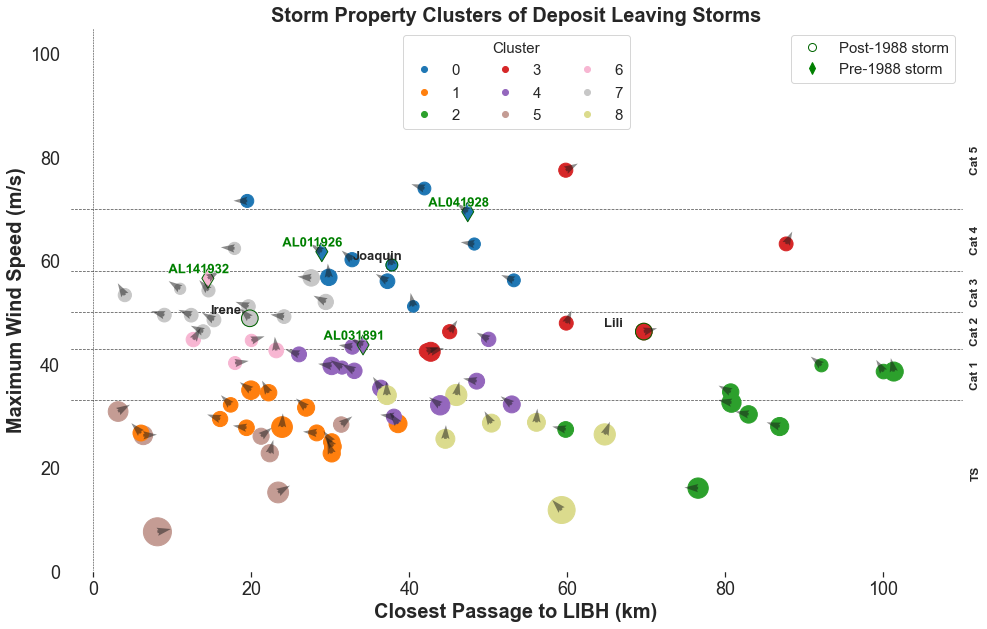

AL141932 6.0 4
AL041928 0.0 8
AL011926 0.0 8
AL031891 4.0 11
Post 1988 Historical:  [3, 0, 6]
Pre 1988 Historical:  [7, 3, 3, 8]


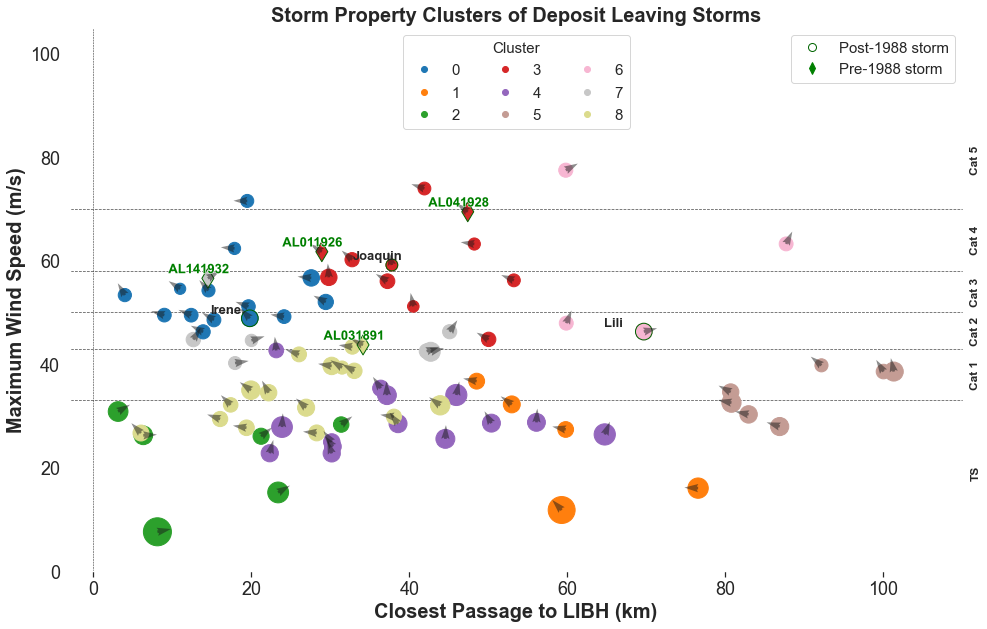

AL141932 7.0 6
AL041928 3.0 8
AL011926 3.0 8
AL031891 8.0 15
Post 1988 Historical:  [7, 1, 6]
Pre 1988 Historical:  [8, 7, 7, 1]


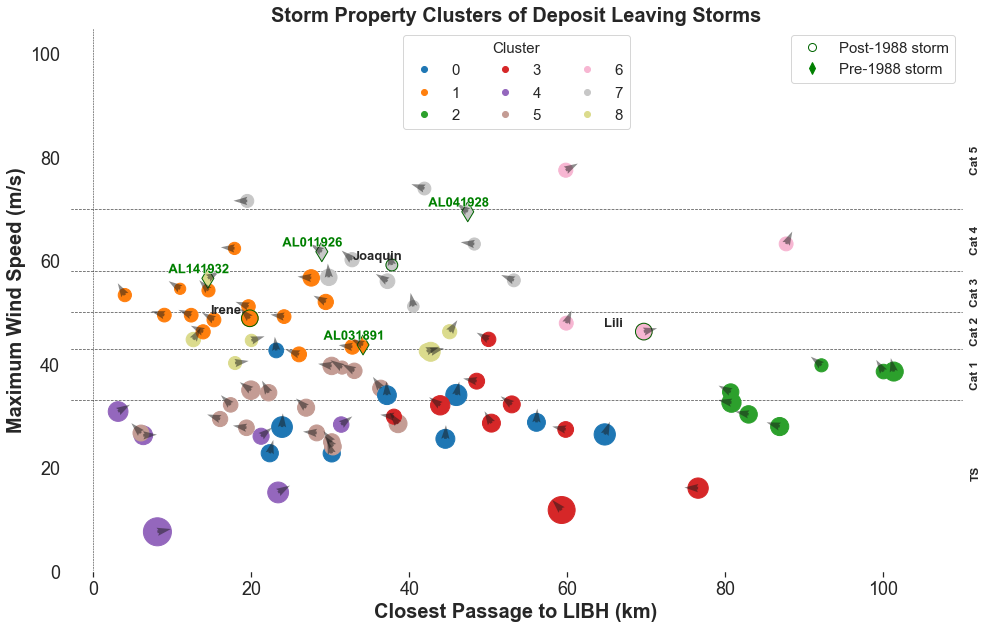

AL141932 8.0 6
AL041928 7.0 8
AL011926 7.0 8
AL031891 1.0 14
Post 1988 Historical:  [4, 0, 7]
Pre 1988 Historical:  [3, 8, 8, 5]


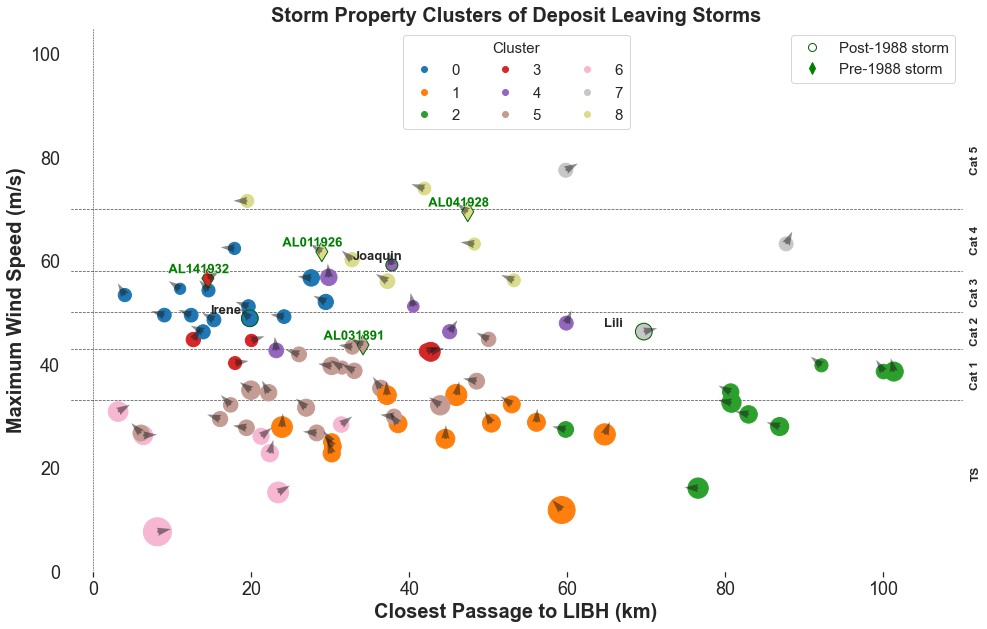

AL141932 3.0 5
AL041928 8.0 6
AL011926 8.0 6
AL031891 5.0 18
Post 1988 Historical:  [4, 8, 6]
Pre 1988 Historical:  [3, 4, 4, 0]


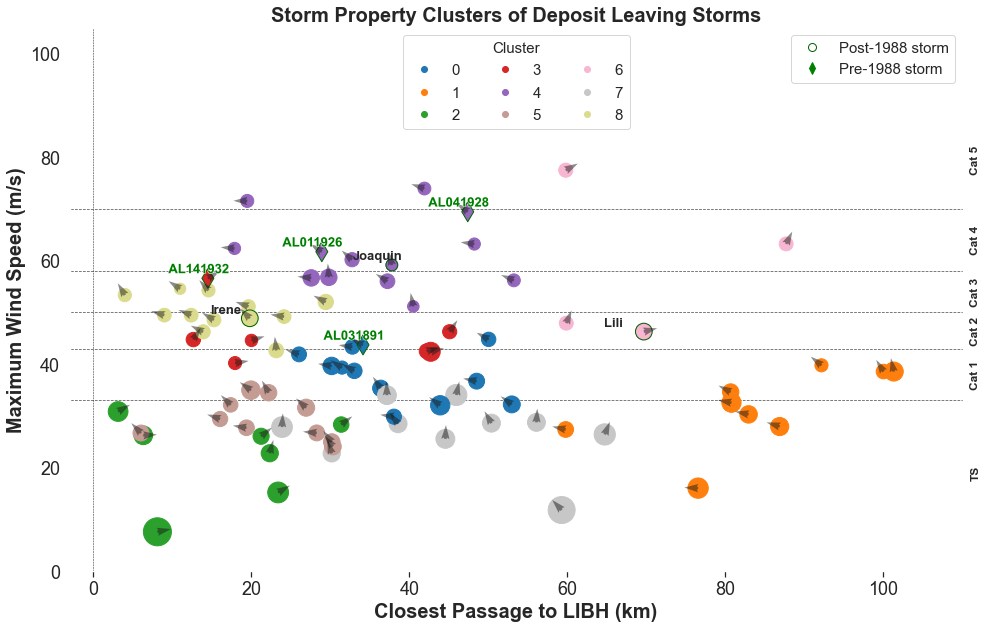

AL141932 3.0 6
AL041928 4.0 10
AL011926 4.0 10
AL031891 0.0 11
Post 1988 Historical:  [8, 6, 5]
Pre 1988 Historical:  [0, 8, 8, 1]


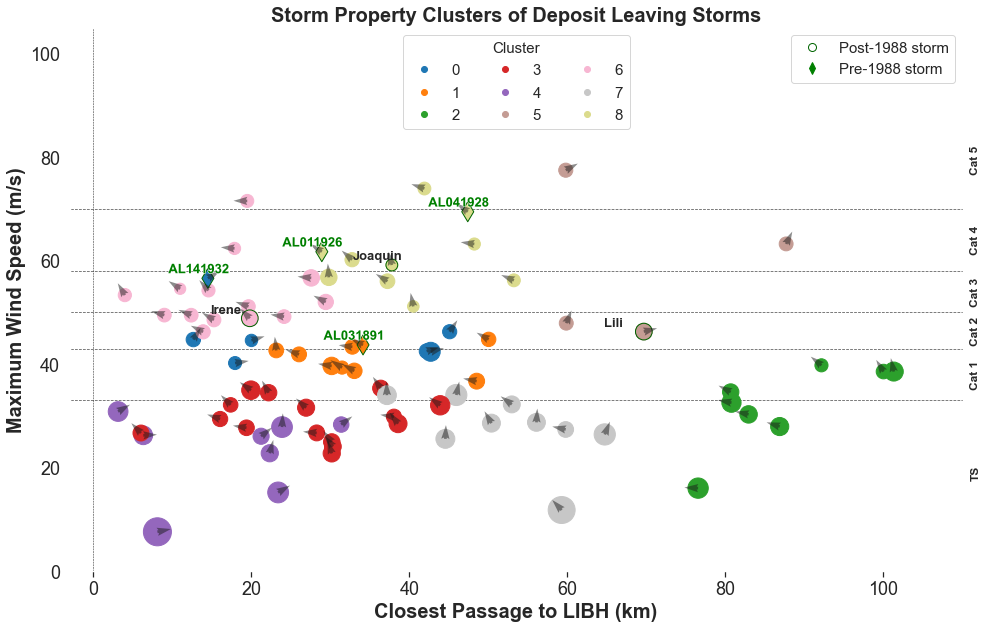

AL141932 0.0 6
AL041928 8.0 7
AL011926 8.0 7
AL031891 1.0 8
Post 1988 Historical:  [0, 7, 8]
Pre 1988 Historical:  [6, 0, 0, 1]


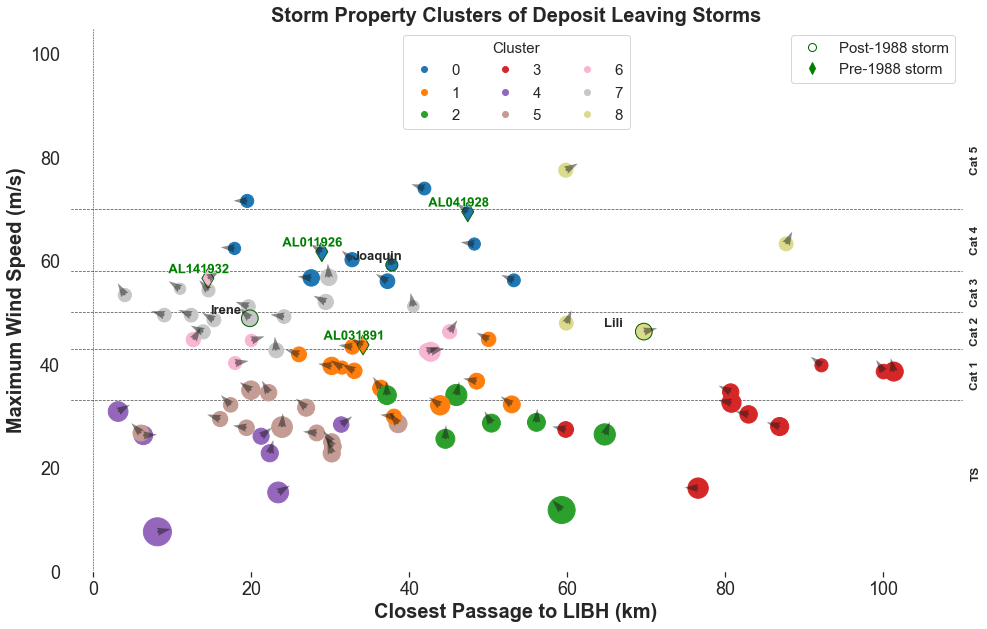

AL141932 6.0 6
AL041928 0.0 8
AL011926 0.0 8
AL031891 1.0 11


In [29]:





names_88 = ["AL141932", "AL041928", "AL011926", "AL031891"]

clus_rm_88 = [[],[],[], []]
dis_clus_88 = [[],[],[], []]

vm_pass_rm = [[],[],[], []]
all_rm = [[],[],[],[]]

num_it = 10

for j in range(num_it):
    cluster_n = 9
    data_clus = scale_and_cluster(data, cluster_n)
    plot_clusters(data_clus, storms_hist, storms_p_1950, cluster_n)
    data_p_1950 = data_clus.iloc[-4:] #post 1988 historical storms


    for i in range(0,len(storms_p_1950)):

        storm_unk = data_p_1950.iloc[i]#storms_p_1950[storms_p_1950.ID == "AL141932"]

        clus = storm_unk.Label
        dat = data_clus[:-7] #don't include historical storms -- only using synthetics as proxies

        print(names_88[i], clus, (len(dat[dat.Label == clus])))

#         fig, ax = plt.subplots(figsize = (6,6))
#         fig.suptitle(names[i])
#         ax.scatter(dat.pass_libh, dat.Vm_rmin, c='b', s = 5*dat.Rm_rmin, alpha = .5)
#         ax.scatter(dat[dat.Label == clus].pass_libh, dat[dat.Label == clus].Vm_rmin, c='g', s=5*dat[dat.Label == clus].Rm_rmin)
#         ax.plot(storm_unk.pass_libh, storm_unk.Vm_rmin, 'r*')
#         ax.set_title("Cluster Only"); ax.set_ylabel("Max Wind (m/s)")


        clus_rm_88[i].extend((dat.Rm_rmin[dat.Label == clus]).values)
#         dis_clus_88[i].extend(np.sqrt((dat[dat.Label == clus].Vm_rmin - storm_unk.Vm_rmin)**2 + (dat[dat.Label == clus].pass_libh - storm_unk.pass_libh)**2))
        
        dis = ((dat[dat.Label == clus].Vm_rmin - storm_unk.Vm_rmin)**2 
               + (dat[dat.Label == clus].pass_libh - storm_unk.pass_libh)**2
              + (dat[dat.Label == clus].Theta - storm_unk.Theta)**2)**.5
        dis_clus_88[i].extend(dis)


        plt.show()

    

1    10.238541
Name: Rm_rmin, dtype: float64 4   -13.333532
Name: Rm_rmin, dtype: float64 9   -12.165097
Name: Rm_rmin, dtype: float64
1    6.53756
Name: Rm_rmin, dtype: float64 4   -8.8044
Name: Rm_rmin, dtype: float64 9   -15.77904
Name: Rm_rmin, dtype: float64
1    0.269304
Name: Rm_rmin, dtype: float64
4    0.512641
Name: Rm_rmin, dtype: float64
9    0.280335
Name: Rm_rmin, dtype: float64


<ipython-input-15-a190cbef8c83>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax[0].boxplot(np.array([np.repeat(np.array(clus_rm[0]),(1000/np.array(dis_clus[0])).astype(int)),
<ipython-input-15-a190cbef8c83>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax[1].boxplot(np.array([np.repeat(np.array(clus_rm_88[0]),(1000/np.array(dis_clus_88[0])).astype(int)),


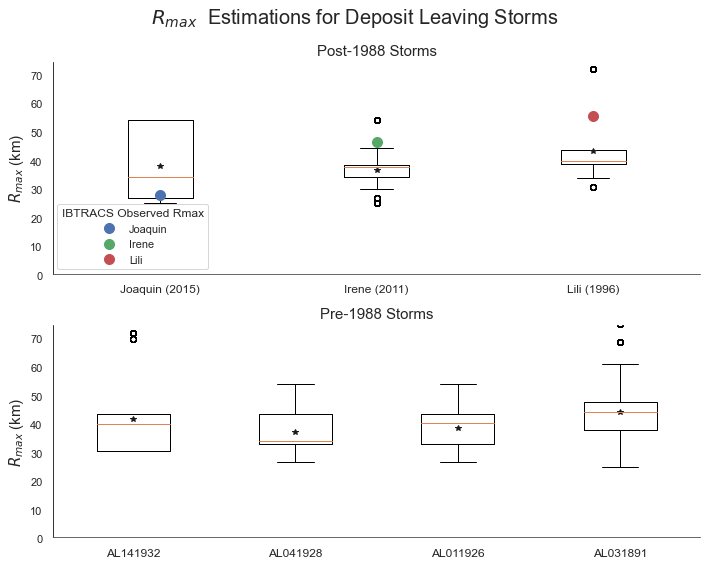

In [15]:
df_rm_est = pd.DataFrame({"Storm":[], "Mean_Rm": [], "Min_Rm": [], "Max_Rm": []})
df_rm_est["Storm"] = names


fig, ax = plt.subplots(2, 1, figsize = (10,8))
# ax[0].boxplot(np.array(clus_rm[0]))
# ax[0].boxplot(np.array([np.array(clus_rm[0]), np.array(clus_rm[1]), np.array(clus_rm[2])]))
ax[0].boxplot(np.array([np.repeat(np.array(clus_rm[0]),(1000/np.array(dis_clus[0])).astype(int)), 
                        np.repeat(np.array(clus_rm[1]),(1000/np.array(dis_clus[1])).astype(int)), 
                        np.repeat(np.array(clus_rm[2]),(1000/np.array(dis_clus[2])).astype(int))]))

ax[0].plot(1, storms_hist[storms_hist.Name == "Joaquin"].Rm_rmin, 'bo', markersize = 10, label = "Joaquin")
ax[0].plot(2, storms_hist[storms_hist.Name == "Irene"].Rm_rmin-(5*1.832), 'go', markersize = 10, label = "Irene")
ax[0].plot(3, storms_hist[storms_hist.Name == "Lili"].Rm_rmin, 'ro', markersize = 10, label = "Lili")


# ax[0].plot(3, 29*1.832, 'r*', markersize = 10, label = "Lili")
# ax[0].plot(2, 25*1.832, 'g*', markersize = 10, label = "Irene")

mean_rm = [np.average(np.array(clus_rm[0]), weights=100/np.array(dis_clus[0])),
          np.average(np.array(clus_rm[1]), weights=100/np.array(dis_clus[1])),
          np.average(np.array(clus_rm[2]), weights=100/np.array(dis_clus[2]))]

ax[0].plot(1, mean_rm[0], 'k*')
ax[0].plot(2, mean_rm[1], 'k*')
ax[0].plot(3, mean_rm[2], 'k*')

# ax[0].plot(1, np.median(np.repeat(np.array(clus_rm[0]),(1000/np.array(dis_clus[0])).astype(int))), 'r*')
# ax[0].plot(2, mean_rm[1], 'r*')
# ax[0].plot(3, mean_rm[2], 'r*')


print(mean_rm[0] - storms_hist[storms_hist.Name == "Joaquin"].Rm_rmin,
     mean_rm[1] - (storms_hist[storms_hist.Name == "Irene"].Rm_rmin-3*1.832),
     mean_rm[2]-storms_hist[storms_hist.Name == "Lili"].Rm_rmin)

print(np.median(np.repeat(np.array(clus_rm[0]),(1000/np.array(dis_clus[0])).astype(int))) - storms_hist[storms_hist.Name == "Joaquin"].Rm_rmin,
     np.median(np.repeat(np.array(clus_rm[1]),(1000/np.array(dis_clus[1])).astype(int))) - (storms_hist[storms_hist.Name == "Irene"].Rm_rmin-5*1.832),
     np.median(np.repeat(np.array(clus_rm[2]),(1000/np.array(dis_clus[2])).astype(int))) - storms_hist[storms_hist.Name == "Lili"].Rm_rmin)
# ax[0].plot(1, np.mean(np.repeat(np.array(clus_rm[0]),(1000/np.array(dis_clus[0])).astype(int))), 'r>')
# ax[0].plot(2, np.mean(np.repeat(np.array(clus_rm[1]),(1000/np.array(dis_clus[1])).astype(int))), 'r>')
# ax[0].plot(3, np.mean(np.repeat(np.array(clus_rm[2]),(1000/np.array(dis_clus[2])).astype(int))), 'r>')


ax[0].plot([.5,.5], [0,75], 'k-', linewidth = 4)
ax[0].plot([.5,3.5], [0,0], 'k-')

# ax.plot([.5,3.5], [30,30], 'g-', label = "Irene Observation")
# ax.text(2, 27, "Irene Observation = 30 nm", color = 'g')
ax[0].set_title(r"Post-1988 Storms", fontsize = 15)
ax[0].set_xticklabels(['Joaquin (2015)', 'Irene (2011)', 'Lili (1996)'], fontsize = 12)
ax[0].set_ylim([0,75])

ax[0].legend(title = "IBTRACS Observed Rmax")

ax[0].set_ylabel(r"$R_{max}$ (km)", fontsize = 15)
# ax[0].set_xlabel("Storm")
# ax[0].text(.75, 15, "NEED TO TEST WEIGHTING", rotation = 15, fontsize = 40, color = 'r')




# ax[1].boxplot(np.array([np.array(clus_rm_88[0]), np.array(clus_rm_88[1]), np.array(clus_rm_88[2]), np.array(clus_rm_88[3])]))
ax[1].boxplot(np.array([np.repeat(np.array(clus_rm_88[0]),(1000/np.array(dis_clus_88[0])).astype(int)), 
                        np.repeat(np.array(clus_rm_88[1]),(1000/np.array(dis_clus_88[1])).astype(int)), 
                        np.repeat(np.array(clus_rm_88[2]),(1000/np.array(dis_clus_88[2])).astype(int)),
                        np.repeat(np.array(clus_rm_88[3]),(1000/np.array(dis_clus_88[3])).astype(int))]))


mean_rm_88 = [np.average(np.array(clus_rm_88[0]), weights=100/np.array(dis_clus_88[0])),
          np.average(np.array(clus_rm_88[1]), weights=100/np.array(dis_clus_88[1])),
          np.average(np.array(clus_rm_88[2]), weights=100/np.array(dis_clus_88[2])),
          np.average(np.array(clus_rm_88[3]), weights=100/np.array(dis_clus_88[3]))]
# df_rm_est["Mean_Rm"] = mean_rm_88

ax[1].plot(1, mean_rm_88[0], 'k*')
ax[1].plot(2, mean_rm_88[1], 'k*')
ax[1].plot(3, mean_rm_88[2], 'k*')
ax[1].plot(4, mean_rm_88[3], 'k*')



print(1-storms_hist[storms_hist.Name == "Joaquin"].Rm_rmin/mean_rm[0])
print(storms_hist[storms_hist.Name == "Irene"].Rm_rmin/mean_rm[1]-1)
print(storms_hist[storms_hist.Name == "Lili"].Rm_rmin/mean_rm[2]-1)

# df_rm_est["Max_Rm"] = np.array(mean_rm_88)+11
# df_rm_est["Min_Rm"] = np.array(mean_rm_88)-11


ax[1].set_xticklabels(["AL141932", "AL041928", "AL011926", "AL031891"], fontsize = 12)
ax[1].set_title(r"Pre-1988 Storms", fontsize = 15)
ax[1].set_ylim([0,75])

ax[1].plot([.5,.5], [0,75], 'k-', linewidth = 4)
ax[1].plot([.5,4.5], [0,0], 'k-')

# ax[1].text(1, 15, "NEED TO TEST WEIGHTING", rotation = 15, fontsize = 40, color = 'r')
ax[1].set_ylabel(r"$R_{max}$ (km)", fontsize = 15)


fig.suptitle(r"$R_{max}$  Estimations for Deposit Leaving Storms", fontsize = 20)
plt.tight_layout()

plt.show()


# df_rm_est.to_csv('pre1950_Rm_est.csv')


In [16]:
t=[np.repeat(np.array(clus_rm[0]),(100/np.array(dis_clus[0])).astype(int)), 
                        np.repeat(np.array(clus_rm[1]),(100/np.array(dis_clus[1])).astype(int)), 
                        np.repeat(np.array(clus_rm[2]),(100/np.array(dis_clus[2])).astype(int))]


t = [l.tolist() for l in t]

t_88 = [np.repeat(np.array(clus_rm_88[0]),(100/np.array(dis_clus_88[0])).astype(int)), 
                        np.repeat(np.array(clus_rm_88[1]),(100/np.array(dis_clus_88[1])).astype(int)), 
                        np.repeat(np.array(clus_rm_88[2]),(100/np.array(dis_clus_88[2])).astype(int)),
                        np.repeat(np.array(clus_rm_88[3]),(100/np.array(dis_clus_88[3])).astype(int))]

t_88 = [l.tolist() for l in t_88]

len(t_88[0])

164

In [17]:
max(data.Rm_rmin)

157.1422

In [18]:
def single_df(clus_rm, clus_rm_88):
    flat_clus_rm = sum(clus_rm, [])
    flat_clus_rm_88 = sum(clus_rm_88, [])

    name_flat = list(np.repeat("Joaquin", len(clus_rm[0])))+list(np.repeat("Irene", len(clus_rm[1])))+list(np.repeat("Lili", len(clus_rm[2])))
    mean_flat = list(np.repeat(mean_rm[0], len(clus_rm[0])))+list(np.repeat(mean_rm[0], len(clus_rm[1])))+list(np.repeat(mean_rm[0], len(clus_rm[2])))

    name_flat_88 = list(np.repeat(names_88[0], 
                                  len(clus_rm_88[0])))+list(np.repeat(names_88[1], 
                                  len(clus_rm_88[1])))+list(np.repeat(names_88[2], 
                                  len(clus_rm_88[2])))+list(np.repeat(names_88[3], 
                                  len(clus_rm_88[3])))

    mean_flat_88 = list(np.repeat(mean_rm_88[0], 
                                  len(clus_rm_88[0])))+list(np.repeat(mean_rm_88[1], 
                                  len(clus_rm_88[1])))+list(np.repeat(mean_rm_88[2], 
                                  len(clus_rm_88[2])))+list(np.repeat(mean_rm_88[3], 
                                  len(clus_rm_88[3])))


    hist_rm = np.array([storms_hist[storms_hist.Name == "Joaquin"].Rm_rmin, storms_hist[storms_hist.Name == "Irene"].Rm_rmin-(5*1.832),
             storms_hist[storms_hist.Name == "Lili"].Rm_rmin, np.nan, np.nan, np.nan, np.nan])

    hist_rm_arr = list(np.repeat(hist_rm[0], 
                                  len(clus_rm[0])))+list(np.repeat(hist_rm[1], 
                                  len(clus_rm[1])))+list(np.repeat(hist_rm[2], 
                                  len(clus_rm[2])))+list(np.repeat(hist_rm[3], 
                                  len(clus_rm_88[0])))+list(np.repeat(hist_rm[3], 
                                  len(clus_rm_88[1])))+list(np.repeat(hist_rm[4], 
                                  len(clus_rm_88[2])))+list(np.repeat(hist_rm[5], 
                                  len(clus_rm_88[3])))



    clus_rm_df = pd.DataFrame(np.append(flat_clus_rm,flat_clus_rm_88), columns = ["Rmax"])
    clus_rm_df["Name"] = np.append(name_flat,name_flat_88)
    clus_rm_df["Mean"] = np.append(mean_flat, mean_flat_88)
    clus_rm_df["Value"] = hist_rm_arr
    clus_rm_df
    
    return clus_rm_df


In [19]:
clus_rm_df = single_df(t, t_88)
# single_df(clus_rm, clus_rm_88)

<ipython-input-18-860661e08c41>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hist_rm = np.array([storms_hist[storms_hist.Name == "Joaquin"].Rm_rmin, storms_hist[storms_hist.Name == "Irene"].Rm_rmin-(5*1.832),


27.335520000000006
21.55728
41.392199999999995
41.392199999999995
24.731608
24.594560000000005
26.22432


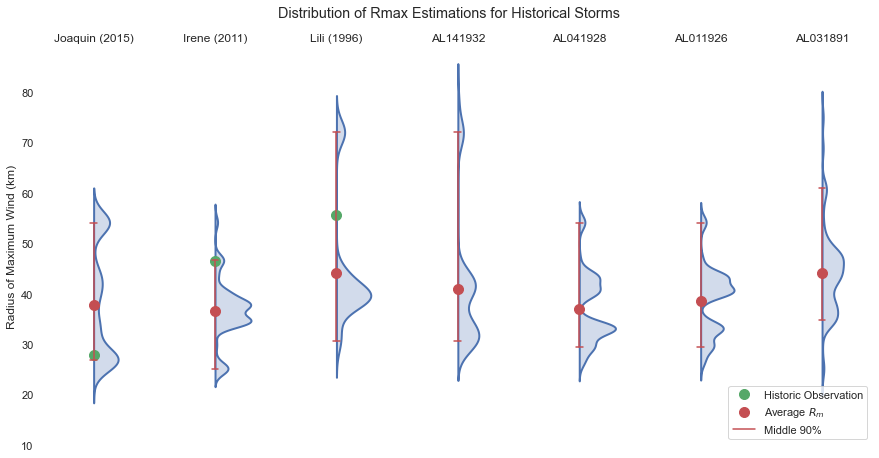

In [20]:
import warnings
warnings.filterwarnings("ignore")
# g = sns.FacetGrid(, row='Name', hue='Rmax', aspect=15, height=0.75, palette=pal)
# sns.set(font_scale=5)

sns.set_theme(style='white')
sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'w', 'xtick.labelsize': 20})


rp = sns.FacetGrid(clus_rm_df, col="Name", aspect=.25, height=7)
rp.map(sns.kdeplot, 'Rmax', clip_on=False,
       shade=True,  alpha=0.25, lw=2, bw=.2, vertical = True)

# rp.map(sns.scatterplot, 'Mean', clip_on=True, markers = True)
def vertical_mean_line_survived(x, hist, **kwargs):
    if hist == False:
#         plt.axhline(x.mean(), linestyle = '--', color = 'r', linewidth = 5)
        plt.plot(0, x.mean(),  'ro', markersize = 10, label = r"Average $R_m$")
#         print(x.mean())
    
#         plt.plot(0, x.mean() + x.std(),  'bo', markersize = 12)
    
    
#         plt.plot([-.01,.01], [x.mean() + 1.2*x.std(), x.mean() + 1.2*x.std()],  'b-', markersize = 12)
#         plt.plot([-.01,.01], [x.mean() - 1.2*x.std(),x.mean() - 1.2*x.std()],  'b-', markersize = 12)
        
        plt.plot([-.01,.01], [np.percentile(x, 5), np.percentile(x, 5)],  'r-', markersize = 20)
        plt.plot([-.01,.01], [np.percentile(x, 95), np.percentile(x, 95)],  'r-', markersize = 20)
        plt.plot([0,0], [np.percentile(x, 5), np.percentile(x, 95)],  'r-', markersize = 20, 
                 label = "Middle 90%")
        
        print(np.percentile(x, 95) - np.percentile(x, 5))

    else:
#         plt.axhline(x.mean(), linestyle = '--', color = 'g', linewidth = 5)
#         plt.xlim([-.05, .05])

        plt.plot(0, x.mean(),  'go',  markersize = 10, label = "Historic Observation")
    

rp.map(vertical_mean_line_survived, 'Value', hist=True) 
rp.map(vertical_mean_line_survived,'Rmax', hist=False) 

# rp.map(historical_reference, 'Value') 
rp.set(ylim=(10, None))
rp.set(xlim=(-.15, .15))

rp.set(xlim=(-.15, .15))
rp.set(xticklabels=[])

rp.set(ylabel= "Radius of Maximum Wind (km)")

rp.set(xlabel="")
plt.legend(loc = "lower right")


#ADJUST NAMES
axes = rp.axes.flatten()
axes[0].set_title("Joaquin (2015)")
axes[1].set_title("Irene (2011)")
axes[2].set_title("Lili (1996)")
axes[3].set_title("AL141932")
axes[4].set_title("AL041928")
axes[5].set_title("AL011926")
axes[6].set_title("AL031891")

rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Distribution of Rmax Estimations for Historical Storms')

plt.show()

Joaquin


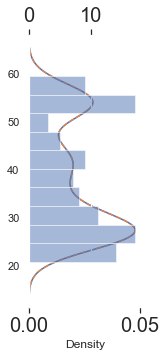

In [21]:
from scipy import stats
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from random import choices


n = 100
ry = np.zeros((len(np.unique(clus_rm_df.Name)), n))

rm_dist = {}

# for i, name in enumerate(np.unique(clus_rm_df.Name)):
for i, name in enumerate(['Joaquin']):

    print(name)
    x = np.array(clus_rm_df[clus_rm_df.Name == name].Rmax)
    eval_points = np.linspace(min(x)-11, max(x)+11, 100)

    kde_sk = KernelDensity(kernel='gaussian')
    kde_sk.fit(x.reshape([-1,1]))
    y_sk = np.exp(kde_sk.score_samples(eval_points.reshape(-1,1)))

    kde_sp = gaussian_kde(x)
    y_sp = kde_sp.pdf(eval_points)

    fig, ax = plt.subplots(figsize = (2,5))
    sns.kdeplot(x, ax = ax, vertical = True)
    # plt.plot(eval_points, y_sk)
    ax.plot(y_sp, eval_points, '--')
    
    rm_dist[name] = [y_sp, eval_points]

    ry[i,:] = choices(eval_points, y_sp, k=n)
    ax1 = ax.twiny()
    ax1.hist(ry[i,:], alpha = .5, orientation="horizontal")
    plt.show()

    
df_rm_samp = pd.DataFrame({"AL011926": ry[0], "AL031891": ry[1], "AL041928": ry[2], "AL141932": ry[3],
                          "Joaquin": ry[4], "Irene": ry[5], "Lili": ry[6]})

# df_rm_samp.to_csv("rm_samples.csv")

In [22]:
ry[i,:]

array([58.49860606, 22.37088485, 22.88699515, 54.36972364, 49.20862061,
       44.04751758, 31.14476   , 33.72531152, 53.85361333, 25.46754667,
       41.98307636, 57.98249576, 27.01587758, 22.88699515, 37.33808364,
       38.88641455, 55.40194424, 52.30528242, 47.6602897 , 41.46696606,
       52.30528242, 33.72531152, 26.49976727, 28.56420848, 52.30528242,
       29.59642909, 31.6608703 , 56.95027515, 23.91921576, 34.75753212,
       52.30528242, 39.40252485, 44.56362788, 27.01587758, 38.37030424,
       23.91921576, 22.37088485, 56.43416485, 43.01529697, 37.85419394,
       40.43474545, 21.85477455, 43.01529697, 35.78975273, 44.04751758,
       52.82139273, 38.88641455, 28.04809818, 28.04809818, 56.43416485,
       28.56420848, 41.98307636, 25.98365697, 42.49918667, 30.11253939,
       54.36972364, 37.33808364, 22.37088485, 53.33750303, 23.40310545,
       50.75695152, 50.24084121, 30.6286497 , 53.85361333, 25.46754667,
       27.53198788, 27.01587758, 52.82139273, 27.53198788, 25.98

In [23]:
import scipy.io as sio

sio.savemat('rm_hist_distribution.mat', rm_dist)

In [24]:
rm_dist = loadmat('rm_hist_distribution.mat')

joa_y = loadmat('christine/yJoaquin.mat'); joa_x = loadmat('christine/xJoaquin.mat')
ire_y = loadmat('christine/yIrene.mat'); ire_x = loadmat('christine/xIrene.mat')
lili_y = loadmat('christine/ylili.mat'); lili_x = loadmat('christine/xlili.mat')
s_1891_y = loadmat('christine/y1918.mat'); s_1891_x = loadmat('christine/x1918.mat')
s_1926_y = loadmat('christine/y1926.mat'); s_1926_x = loadmat('christine/x1926.mat')
s_1928_y = loadmat('christine/y1928.mat'); s_1928_x = loadmat('christine/x1928.mat')
s_1932_y = loadmat('christine/y1932.mat'); s_1932_x = loadmat('christine/x1932.mat')


In [25]:
for i in range(len(surge_x)):
    draw = choice(surge_x[i][0], 100,
              p=surge_y[i][0]/np.sum(surge_y[i]))

    print(max(draw), min(draw), np.mean(draw))
#     print(np.median(surge_x[i]))

NameError: name 'surge_x' is not defined

In [57]:
np.sum(surge_y[i][0]/np.sum(surge_y[i]))

1.0000000000000002

In [60]:
from numpy.random import choice


0.945 0.73 0.8277499999999999


KeyError: 'Irene'

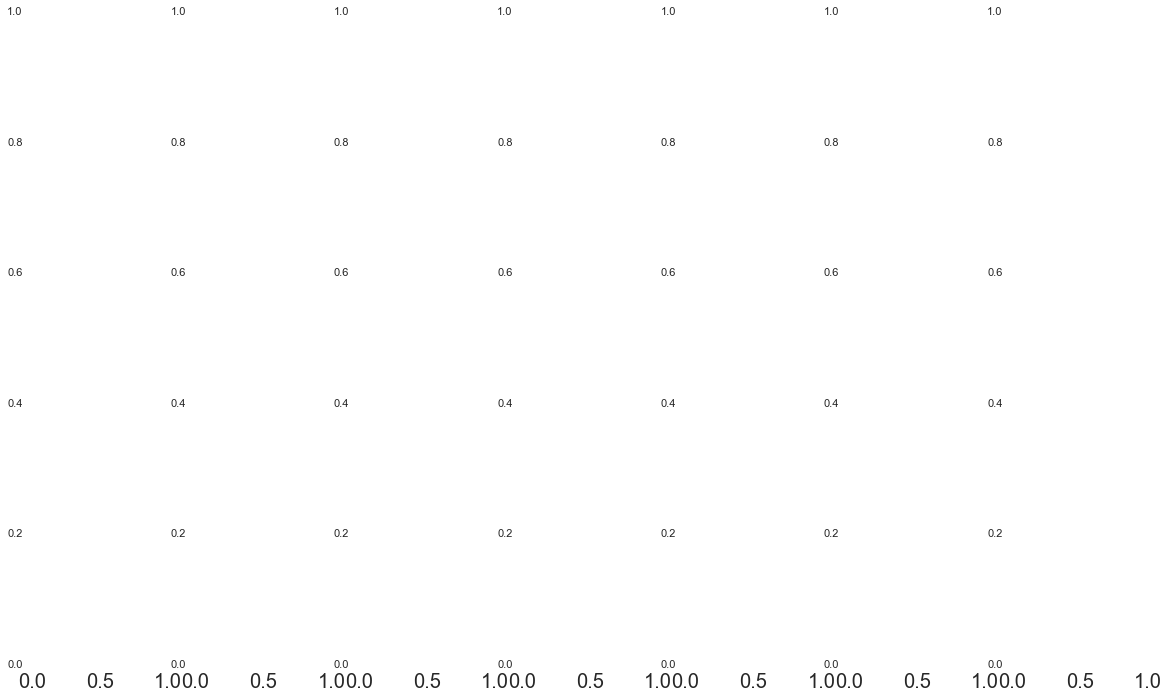

In [26]:
fig, ax = plt.subplots(1, 7, figsize = (20, 12))

surge_y = [joa_y['yJoaquin'], ire_y['yIrene'], lili_y['ylili'], s_1932_y['y1932'],
          s_1928_y['y1928'], s_1926_y['y1926'], s_1891_y['y1918']][::-1]
surge_x = [joa_x['xJoaquin'], ire_x['xIrene'], lili_x['xlili'], s_1932_x['x1932'],
          s_1928_x['x1928'], s_1926_x['x1926'], s_1891_x['x1918']][::-1]
rm_storm = [rm_dist['Joaquin'], rm_dist['Irene'], rm_dist['Lili'], rm_dist['AL141932'],
           rm_dist['AL041928'], rm_dist['AL011926'], rm_dist['AL031891']][::-1]

name = ["Joaquin (2015)","Irene (2011)","Lili (1996)","AL141932","AL041928","AL011926","AL031891"][::-1]

obs_rm = [clus_rm_df[clus_rm_df.Name == 'Joaquin'].Value.iloc[0], clus_rm_df[clus_rm_df.Name == 'Irene'].Value.iloc[0],
         clus_rm_df[clus_rm_df.Name == 'Lili'].Value.iloc[0]][::-1]
obs_surge = [storms_hist[storms_hist.Name == 'Joaquin']['Max Surge (m)'], storms_hist[storms_hist.Name == 'Irene']['Max Surge (m)'],
            storms_hist[storms_hist.Name == 'Lili']['Max Surge (m)']][::-1]

for i in range(len(ax)):
    axi = ax[i].twinx() #FOR SURGE
    axi.fill_betweenx(np.array(surge_x[i][0]), np.array(surge_y[i][0])/max(np.array(surge_y[i][0]))*.75, np.zeros(len(surge_y[i])),
                       facecolor = 'b', alpha = .5)
    ax[i].fill_betweenx(rm_storm[i][1], -rm_storm[i][0]/max(rm_storm[i][0])*.75, np.zeros(len(rm_storm[i][0])), facecolor = 'red', alpha = .35)

    axi.plot(np.array(surge_y[i][0])/max(np.array(surge_y[i][0]))*.75, np.array(surge_x[i][0]), linewidth = 3)
    ax[i].plot(-rm_storm[i][0]/max(rm_storm[i][0])*.75, rm_storm[i][1], 'red', linewidth = 3, alpha = .75)

#     axi.scatter(0,np.median(np.array(surge_x[i][0])), c='g', s = 100, alpha = 1)
#     axi.scatter(0,np.mean(np.array(surge_x[i][0])), c='y', s = 100, alpha = 1)
        
    ax[i].set_ylim([10,85]); axi.set_ylim([0,2.2]); axi.set_xlim(-1,1); 
    ax[i].set(xticklabels=[])
    ax[i].set_title(name[i], fontsize = 18)
    ax[i].yaxis.label.set_color('red'); ax[i].tick_params(axis='y', colors='red')
    axi.yaxis.label.set_color('b'); axi.tick_params(axis='y', colors='b')
    
    if i == len(ax)-5:
        h1, = plt.plot([],[], 'o', color = "r", markersize=8); h2, = plt.plot([],[], "o", color = "b", markersize=8)
        labels = [r'Observed $R_{max}$', "Observed Max Storm Tide"]
        legend = axi.legend([h1,h2], labels, loc="upper right",  fontsize = 15)

    if i >3:
        ax[i].scatter(0,obs_rm[i-4], c='red', s = 100, alpha = .75)
        axi.scatter(0,obs_surge[i-4], c='b', s = 100, alpha = 1)    
    
    if i >0:
        ax[i].set(yticklabels=[], yticks=[])
    if i <len(ax)-1:
        axi.set(yticklabels=[], yticks=[])
    if i == 0:
        ax[i].set_ylabel('Radius of Maximum Wind (km)', fontsize = 15)
    if i ==len(ax)-1:
        axi.set_ylabel('Maximum Storm Tide (m)', fontsize = 15)
        
    axi.grid(False)
        
        
fig.suptitle('Distribution of Size and Storm Tide Estimations for Historical Storms', fontsize = 20, fontweight = 'bold')
plt.show()


In [187]:
test_75[:8]

0    2015.34
1    2014.34
2    2014.34
3    2013.02
4    2012.36
5    2011.70
6    2010.70
7    2010.04
Name: 0.67, dtype: float64

In [215]:
surge_x_[6]

array([[0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675, 0.68 , 0.685, 0.69 ,
        0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 , 0.725, 0.73 , 0.735,
        0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765, 0.77 , 0.775, 0.78 ,
        0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 , 0.815, 0.82 , 0.825,
        0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855, 0.86 , 0.865, 0.87 ,
        0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  , 0.905, 0.91 , 0.915,
        0.92 , 0.925, 0.93 , 0.935, 0.94 , 0.945, 0.95 , 0.955, 0.96 ,
        0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 , 0.995, 1.   ]])

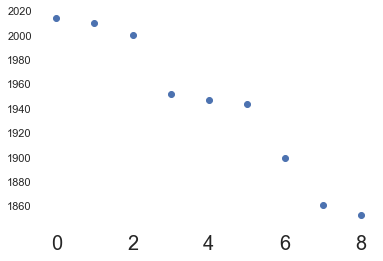

In [210]:
plt.plot(test_75[(test_75>1850) & (sed.event_indx==1)], 'o')

2014.34 0
2010.04 1
2000.0 2
1951.56 3
1946.54 4
1943.2 5
1899.2 6


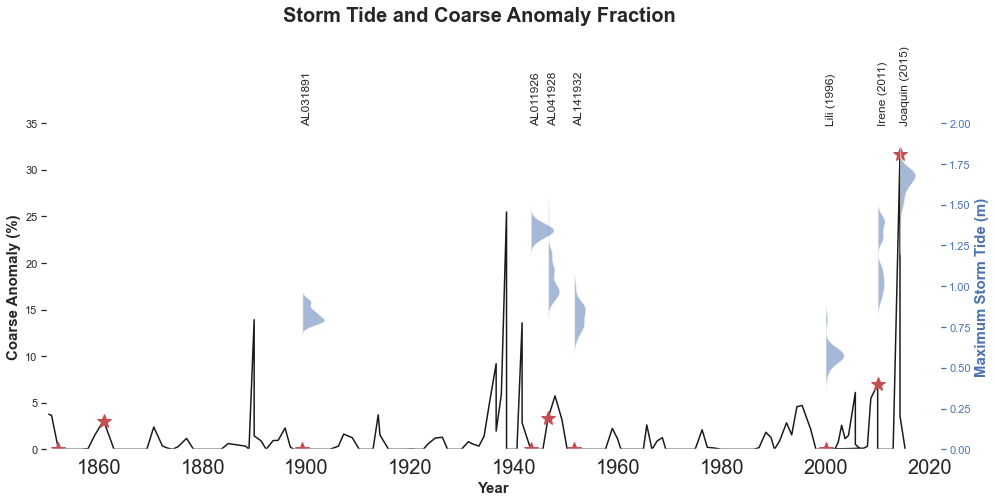

In [216]:
sed = pd.read_csv("../sediment_data.csv")
sed["mean_age"] = sed.loc[:, ["max_age", "min_age"]].mean(axis=1)
#np.mean((sed["max_age"], sed["min_age"]), axis = 1)
fig, ax = plt.subplots(figsize = (16,6))

test_75_ = (sed.loc[:, ["max_age", "median_age", "min_age"]].T).quantile(0.67)


t = np.append(np.array(sed.coarse_anom[:12]), ((np.array([0,0,0, 0, 0,0,0,0,0]))))# + test_75[8:]
sed_ca= np.append(t, np.array(sed.coarse_anom[12:]))[:len(sed.coarse_anom)]


t = np.append(np.array(test_75_[:12]), ((np.ones(9))*2000))# + test_75[8:]
test_75= np.append(t, np.array(test_75_[12:]))[:len(test_75_)]

# ax.plot(sed.median_age, sed.coarse_anom, 'k')
ax.plot(test_75, sed_ca, 'k')

# ax.plot(sed.median_age[sed.event_indx==1], sed.coarse_anom[sed.event_indx==1], 'r*', markersize = 8)

ax1 = ax.twinx()
ax1.grid(False)
surge_x_ = surge_x[::-1]
surge_y_ = surge_y[::-1]
name_ = name[::-1]

low_ = [1.77, .4, .375, .75, 1.5, .5, .75]

for i, yr in enumerate(test_75[(test_75>1890) & (sed.event_indx==1)]):
    print(yr, i)
    ax1.fill_betweenx(np.array(surge_x_[i][0]), np.array(surge_y_[i][0])/2 + yr, np.ones(len(surge_y_[i]))*yr,
                       facecolor = 'b', alpha = .5)
    ax1.plot(np.array(surge_x_[i][0]), np.array(surge_y_[i][0])/2 + yr, 'b', linewidth = 3)
    
#     ax1.plot([yr, yr], [low_[i], np.max(surge_x_[i])], 'b--')
    
    ax1.text(yr,2, name_[i], rotation = 90)

    
ax.plot(test_75[(test_75>1850) & (sed.event_indx==1)], sed_ca[(test_75>1850) & (sed.event_indx==1)], '*', color = 'r', markersize = 15)

    
ax.set_xlim([1850, 2022])
ax.set_ylim([0,35]); ax1.set_ylim([0,2])

ax.set_xlabel("Year", fontweight="bold", fontsize = 15)
ax.set_ylabel("Coarse Anomaly (%)", fontweight="bold", fontsize = 15)
ax1.set_ylabel("Maximum Storm Tide (m)", fontweight="bold", fontsize = 15)
ax1.yaxis.label.set_color('b'); ax1.tick_params(axis='y', colors='b')

fig.suptitle('Storm Tide and Coarse Anomaly Fraction', fontsize = 20, fontweight = 'bold', y = 1.15)

plt.show()

In [47]:
fig, ax = plt.subplots(1, 7, figsize = (20, 12))

surge_y = [joa_y['yJoaquin'], ire_y['yIrene'], lili_y['ylili'], s_1932_y['y1932'],
          s_1928_y['y1928'], s_1926_y['y1926'], s_1891_y['y1918']][::-1]
surge_x = [joa_x['xJoaquin'], ire_x['xIrene'], lili_x['xlili'], s_1932_x['x1932'],
          s_1928_x['x1928'], s_1926_x['x1926'], s_1891_x['x1918']][::-1]
rm_storm = [rm_dist['Joaquin'], rm_dist['Irene'], rm_dist['Lili'], rm_dist['AL141932'],
           rm_dist['AL041928'], rm_dist['AL011926'], rm_dist['AL031891']][::-1]

name = ["Joaquin (2015)","Irene (2011)","Lili (1996)","AL141932","AL041928","AL011926","AL031891"][::-1]

obs_rm = [clus_rm_df[clus_rm_df.Name == 'Joaquin'].Value.iloc[0], clus_rm_df[clus_rm_df.Name == 'Irene'].Value.iloc[0],
         clus_rm_df[clus_rm_df.Name == 'Lili'].Value.iloc[0]][::-1]
obs_surge = [storms_hist[storms_hist.Name == 'Joaquin']['Max Surge (m)'], storms_hist[storms_hist.Name == 'Irene']['Max Surge (m)'],
            storms_hist[storms_hist.Name == 'Lili']['Max Surge (m)']][::-1]

for i in range(len(ax)):
    axi = ax[i].twinx() #FOR SURGE
    axi.fill_betweenx(np.array(surge_x[i][0]), np.array(surge_y[i][0])/max(np.array(surge_y[i][0]))*.75, np.ones(len(surge_y[i]))*year,
                       facecolor = 'b', alpha = .5)
    ax[i].fill_betweenx(rm_storm[i][1], -rm_storm[i][0]/max(rm_storm[i][0])*.75, np.zeros(len(rm_storm[i][0])), facecolor = 'red', alpha = .35)

    axi.plot(np.array(surge_y[i][0])/max(np.array(surge_y[i][0]))*.75, np.array(surge_x[i][0]), linewidth = 3)
    ax[i].plot(-rm_storm[i][0]/max(rm_storm[i][0])*.75, rm_storm[i][1], 'red', linewidth = 3, alpha = .75)

#     axi.scatter(0,np.median(np.array(surge_x[i][0])), c='g', s = 100, alpha = 1)
#     axi.scatter(0,np.mean(np.array(surge_x[i][0])), c='y', s = 100, alpha = 1)
        
    ax[i].set_ylim([10,85]); axi.set_ylim([0,2.2]); axi.set_xlim(-1,1); 
    ax[i].set(xticklabels=[])
    ax[i].set_title(name[i], fontsize = 18)
    ax[i].yaxis.label.set_color('red'); ax[i].tick_params(axis='y', colors='red')
    axi.yaxis.label.set_color('b'); axi.tick_params(axis='y', colors='b')
    
    if i == len(ax)-5:
        h1, = plt.plot([],[], 'o', color = "r", markersize=8); h2, = plt.plot([],[], "o", color = "b", markersize=8)
        labels = [r'Observed $R_{max}$', "Observed Max Storm Tide"]
        legend = axi.legend([h1,h2], labels, loc="upper right",  fontsize = 15)

    if i >3:
        ax[i].scatter(0,obs_rm[i-4], c='red', s = 100, alpha = .75)
        axi.scatter(0,obs_surge[i-4], c='b', s = 100, alpha = 1)    
    
    if i >0:
        ax[i].set(yticklabels=[], yticks=[])
    if i <len(ax)-1:
        axi.set(yticklabels=[], yticks=[])
    if i == 0:
        ax[i].set_ylabel('Radius of Maximum Wind (km)', fontsize = 15)
    if i ==len(ax)-1:
        axi.set_ylabel('Maximum Storm Tide (m)', fontsize = 15)
        
    axi.grid(False)
        
        
fig.suptitle('Distribution of Size and Storm Tide Estimations for Historical Storms', fontsize = 20, fontweight = 'bold')
plt.show()


[1    1.39
 Name: Max Surge (m), dtype: float64,
 4    1.0
 Name: Max Surge (m), dtype: float64,
 9    0.67
 Name: Max Surge (m), dtype: float64]

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data = storms
X = data[['Closest Passage (km)', 'Angle of Passage', 'Vm_rmin', 'U', "V"]]#data.drop(axis=1, columns=['Closest Passage (km)', 'Angle of Passage', 'Vm_rmin', ])
y = data['Rm_rmin']#pd.concat([data['Y1'], data['Y2']], axis=1)

model = LinearRegression()
model.fit(X, y)
y_hat = model.predict(X)

r_sq = model.score(X, y)
print(r_sq)

mse = mean_squared_error(y, y_hat)
print(mse)

0.615398475712358
265.8747693038832


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# X = data.drop(axis=1, columns=['Y1', 'Y2'])
# y = pd.concat([data['Y1'], data['Y2']], axis=1)

network = Sequential()
network.add(Dense(8, input_shape=(np.shape(X)[0]), activation='sigmoid'))
# network.add(Dense(6, activation='relu'))
# network.add(Dense(6, activation='relu'))
# network.add(Dense(4, activation='relu'))
network.add(Dense(2, activation='relu'))

network.compile('adam', loss='mse', metrics=['mse'])
network.fit(X, y, epochs=1000)